Global config

In [44]:
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
size=25
plt.rc('font', size=   size) 
plt.rc('font', serif='Arial') 

# Clustering analysis

## clustering

Step to perform clustering analysis:

01: coordinate

02: round1 clustering

03: estimate optimal number with silhouette index

04: compute paired wise BC distance & remove outlier within each cluster

05: round2 clustering

06: re-estimate optimal number with silhouette index

In [109]:
import numpy as np
import pandas as pd
from sklearn.metrics import silhouette_score
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

def est_cluster_number(cs_paths_dict,profile,idx="silhouette",rounds=100,cs_range=[2,20]):
    avg_sil = pd.DataFrame()
    iter_=0
    for j in range(rounds):
        for i,num in enumerate(np.arange(cs_range[0],cs_range[1])):
            cs = pd.read_csv(cs_paths_dict[num],index_col = 0)
            cs = cs.loc[profile.index,:] ## make sure same index
            cs = cs.reset_index()
            
            # repeat-sampling 
            rnd = np.random.randint(low=0,high=len(cs),size=len(cs)-1)
            cs = cs.loc[rnd,:].sort_index()

            profile1 = profile.loc[cs.loc[:,'index'].values,:]
            try:
                silhouette_avg = silhouette_score(profile1.values, cs.cluster)
                avg_sil.loc[iter_,'Num'] = num
                avg_sil.loc[iter_,'Sihouette'] = silhouette_avg
                #print('>>',num,':',np.round(silhouette_avg,3))
                #avg_sil.append(np.round(silhouette_avg,3))
            except ValueError:
                ## 所有样本都抽到同一个类
                pass
            iter_ +=1  
    
    # reformat
    avg_sil.Num = avg_sil.Num.astype(int)
    css = set(avg_sil.Num)
    sil_arr = [[] for i in range(len(css))]
    for i,cs in enumerate(css):
        print(i,cs)
        cur_sils = avg_sil[avg_sil.loc[:,'Num'] == cs]
        for sil in cur_sils.loc[:,'Sihouette'].values:
            sil_arr[i].append(sil)
    return avg_sil,sil_arr

def plot_avg_sil(sil_arr,
                 cs_range:list,
                 save_path=None
                ):

    plt.rc('font', family='Arial')
    plt.rc('font', size=20)
    fig = plt.figure(figsize=(6,5))
    fig.set_facecolor('white')
    ax = fig.subplots()
    bp = ax.boxplot(sil_arr,
                labels = np.arange(cs_range[0],cs_range[1]),
                notch=True,
                meanprops = {'color':'black'},
                widths =0.8,
                medianprops ={'color':'black','linewidth':1.5},
                flierprops =dict(marker="o",markersize=3),
                #atch_artist=True
                #labels = avg_sil.Num.values
                  #notch=True

                  )
    # changing color and linewidth of whiskers 
    for whisker in bp['whiskers']: 
        whisker.set(
                #color ='#8B008B', 
                    linewidth = 1.5, 
                    linestyle =":") 

    #plt.plot(avg_sil)

    for i,artist in enumerate(ax.artists):
        col = artist.get_facecolor()
        artist.set_edgecolor(col)
        artist.set_facecolor('None')
        for j in range(i*6,i*6+6):
            line = ax.lines[j]
            line.set_color(col)
            line.set_mfc(col)
            line.set_mec(col)
        for j in range(i*6+2,i*6+4):
            line = ax.lines[j]
            line.set_color('None')
    plt.ylabel('Average silhouette width')
    plt.xlabel('Number of clusters')
    
    #plt.show()
    if save_path:
        fig.savefig(save_path,
                     bbox_inches="tight",
                     dpi=800)
    return fig,ax
def clustering_in_r(profile_path,odir,max_num=20):
    importr("cluster")
    rcode="""
    ## Hierarchical clustering
    hc_method= "complete"
    hclusCut <- function(x, k, d.meth = "euclidean", method=hc_method) list(cluster = cutree(hclust(dist(x, method=d.meth), method=method), k=k))
    idir=c("{profile_path}")
    odir=c("{odir}")
    
    nums=c(2:{max_num})
    ##1.load
    cord=read.csv(idir,
                stringsAsFactors = FALSE,row.names=1,check.names=F)

    for(num in nums){{
        hcl.complete = hclusCut(cord,k=num)
        ofile=c("cord_hclust_",hc_method,"_",num,".csv")
        ofile=paste(ofile, collapse = "")
        ofile=paste0(odir,ofile)
        print(ofile)
        write.csv(hcl.complete ,ofile)    
    }}
    """.format(profile_path = profile_path,odir = odir,max_num = max_num)
    #print(rcode)
    robjects.r(rcode)
    print("clustering done")
    return 
def get_bc_dist(profile_path,save_path):
    importr("vegan")
    rcode = """
    rel.matr <- read.csv('{profile_path}',stringsAsFactors = FALSE,row.names=1,check.names=F)
    
    bray = as.matrix(vegdist(rel.matr, "bray"))
    
    write.csv(bray,
              '{save_path}')
    
    """.format(profile_path = profile_path,save_path = save_path)
    robjects.r(rcode)
    print("bc dist done")
    return 

In [ ]:
## 01: bc_coord.r

### 02: round1 clustering

In [61]:

ipath = "E:/ncovKLZ/final_scripts_published/clustering/bray_cord_raw.csv"
odir_ = "E:/ncovKLZ/final_scripts_published/clustering/round1/"
clustering_in_r(ipath,odir_,max_num=16)

[1] "E:/ncovKLZ/final_scripts_published/clustering/round1/cord_hclust_complete_2.csv"
[1] "E:/ncovKLZ/final_scripts_published/clustering/round1/cord_hclust_complete_3.csv"
[1] "E:/ncovKLZ/final_scripts_published/clustering/round1/cord_hclust_complete_4.csv"
[1] "E:/ncovKLZ/final_scripts_published/clustering/round1/cord_hclust_complete_5.csv"
[1] "E:/ncovKLZ/final_scripts_published/clustering/round1/cord_hclust_complete_6.csv"
[1] "E:/ncovKLZ/final_scripts_published/clustering/round1/cord_hclust_complete_7.csv"
[1] "E:/ncovKLZ/final_scripts_published/clustering/round1/cord_hclust_complete_8.csv"
[1] "E:/ncovKLZ/final_scripts_published/clustering/round1/cord_hclust_complete_9.csv"
[1] "E:/ncovKLZ/final_scripts_published/clustering/round1/cord_hclust_complete_10.csv"
[1] "E:/ncovKLZ/final_scripts_published/clustering/round1/cord_hclust_complete_11.csv"
[1] "E:/ncovKLZ/final_scripts_published/clustering/round1/cord_hclust_complete_12.csv"
[1] "E:/ncovKLZ/final_scripts_published/clustering/

### 03: estimate optimal number with silhouette index

In [81]:

import os
dir_ = "E:/ncovKLZ/final_scripts_published/clustering/round1/"
css_csv = os.listdir(dir_)
hc_css_csv = [i for i in css_csv if 'hclust' in i]
hc_dict = dict(zip([int(i.split('_')[3].split('.')[0]) for i in hc_css_csv],
                   [ dir_ + i for i in hc_css_csv]))

hc_dict

{10: 'E:/ncovKLZ/final_scripts_published/clustering/round1/cord_hclust_complete_10.csv',
 11: 'E:/ncovKLZ/final_scripts_published/clustering/round1/cord_hclust_complete_11.csv',
 12: 'E:/ncovKLZ/final_scripts_published/clustering/round1/cord_hclust_complete_12.csv',
 13: 'E:/ncovKLZ/final_scripts_published/clustering/round1/cord_hclust_complete_13.csv',
 14: 'E:/ncovKLZ/final_scripts_published/clustering/round1/cord_hclust_complete_14.csv',
 15: 'E:/ncovKLZ/final_scripts_published/clustering/round1/cord_hclust_complete_15.csv',
 16: 'E:/ncovKLZ/final_scripts_published/clustering/round1/cord_hclust_complete_16.csv',
 2: 'E:/ncovKLZ/final_scripts_published/clustering/round1/cord_hclust_complete_2.csv',
 3: 'E:/ncovKLZ/final_scripts_published/clustering/round1/cord_hclust_complete_3.csv',
 4: 'E:/ncovKLZ/final_scripts_published/clustering/round1/cord_hclust_complete_4.csv',
 5: 'E:/ncovKLZ/final_scripts_published/clustering/round1/cord_hclust_complete_5.csv',
 6: 'E:/ncovKLZ/final_scripts

In [82]:
profile = pd.read_csv(ipath,index_col = 0)
avg_sil,sil_arr = est_cluster_number(hc_dict,profile,idx="silhouette",rounds=100,cs_range=[2,17])

0 2
1 3
2 4
3 5
4 6
5 7
6 8
7 9
8 10
9 11
10 12
11 13
12 14
13 15
14 16


silhouette index in round 1 identify 12 as the optimal partition number.

(<Figure size 432x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1bd134b50b8>)

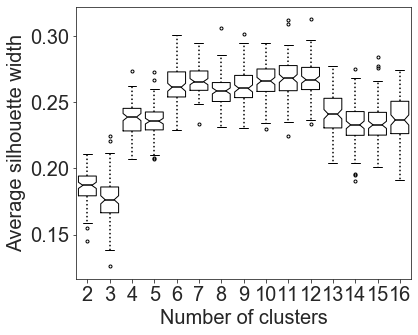

In [83]:
plot_avg_sil(sil_arr,
                 cs_range=[2,17],
                 save_path=None
                )

### 04: remove outlier within each cluster

In [84]:
## compute paired wise BC distance & remove outlier within each cluster

dir_ = "E:/ncovKLZ/final_scripts_published/clustering/"
meta = pd.read_csv(dir_  + "round1/"+"cord_hclust_complete_12.csv",index_col = 0)
bray_dist = pd.read_csv(dir_ + 'bray_pairwise_dist_genus.csv',index_col=0)


import numpy as np
from collections import defaultdict
mean_dist = defaultdict(dict)

css = set(meta.cluster)
for cs in css:
    cs_ = meta[meta.cluster ==cs]
    for i in cs_.index:
        cur_dist = []
        for j in cs_.index:
            dist = bray_dist.loc[i,j]
            if dist>0:
                cur_dist.append(dist)
        mean_dist[cs][i] = np.mean(cur_dist)

thres= 0.698
discard_sam = defaultdict(list)
for cs in mean_dist.keys():
    for sam in mean_dist[cs].keys():
        if mean_dist[cs][sam] >=thres:
            discard_sam[cs].append(sam)
for i in discard_sam.keys():
    discard_sam[i].sort()



In [85]:
discard_sam

defaultdict(list,
            {2: ['P101_TS_d10', 'P58_TS_d14', 'P86_TS_d5'],
             3: ['P104_TS_d5',
              'P125_TS_d5',
              'P201_TS_d1',
              'P211_TS_d1',
              'P49_TS_d1',
              'P55_TS_d21',
              'P5_TS_d21',
              'P61_TS_d5']})

In [86]:
disc= [i for j in discard_sam.values() for i in j]

check the number of each cluster,since the number of cs 8 and 12 were less than 5, cs 8 and 12 were also defined as outliers.

In [89]:
meta.reset_index().groupby("cluster").count()

,index
cluster,
1,428
2,61
3,67
4,7
5,40
6,16
7,6
8,2
9,9


In [87]:
disc

['P101_TS_d10',
 'P58_TS_d14',
 'P86_TS_d5',
 'P104_TS_d5',
 'P125_TS_d5',
 'P201_TS_d1',
 'P211_TS_d1',
 'P49_TS_d1',
 'P55_TS_d21',
 'P5_TS_d21',
 'P61_TS_d5']

In [90]:
disc2 = list(meta[meta.cluster.isin([8,12])].index)
for i in disc2:
    disc.append(i)

In [91]:
disc

['P101_TS_d10',
 'P58_TS_d14',
 'P86_TS_d5',
 'P104_TS_d5',
 'P125_TS_d5',
 'P201_TS_d1',
 'P211_TS_d1',
 'P49_TS_d1',
 'P55_TS_d21',
 'P5_TS_d21',
 'P61_TS_d5',
 'P47_TS_d1',
 'P103_TS_d10',
 'P164_TS_d21',
 'P166_TS_d10',
 'P167_TS_d10']

In [93]:
dir_ = "E:/ncovKLZ/final_scripts_published/clustering/"
all_ = pd.read_csv(dir_ + "bind_genus_2_001.csv",index_col = 0)
for i in disc:
    if i in all_.columns:
        all_ = all_.drop(i,axis=1)

In [94]:
all_.to_csv(dir_ + "bind_genus_2_001_csfilter.csv")

In [99]:
ipath = "E:/ncovKLZ/final_scripts_published/clustering/bray_cord_raw.csv"
cord_ = pd.read_csv(ipath,index_col = 0)

In [101]:
for i in disc:
    if i in cord_.columns:
        cord_ = cord_.drop(i,axis=1)

In [102]:
cord_.to_csv(dir_ + "bray_cord_csfilter.csv")

### 05: round2 clustering

In [103]:
profile_path = "E:/ncovKLZ/final_scripts_published/clustering/bray_cord_csfilter.csv"
odir = "E:/ncovKLZ/final_scripts_published/clustering/round2/"
max_num=16
clustering_in_r(profile_path,odir,max_num=max_num)

[1] "E:/ncovKLZ/final_scripts_published/clustering/round2/cord_hclust_complete_2.csv"
[1] "E:/ncovKLZ/final_scripts_published/clustering/round2/cord_hclust_complete_3.csv"
[1] "E:/ncovKLZ/final_scripts_published/clustering/round2/cord_hclust_complete_4.csv"
[1] "E:/ncovKLZ/final_scripts_published/clustering/round2/cord_hclust_complete_5.csv"
[1] "E:/ncovKLZ/final_scripts_published/clustering/round2/cord_hclust_complete_6.csv"
[1] "E:/ncovKLZ/final_scripts_published/clustering/round2/cord_hclust_complete_7.csv"
[1] "E:/ncovKLZ/final_scripts_published/clustering/round2/cord_hclust_complete_8.csv"
[1] "E:/ncovKLZ/final_scripts_published/clustering/round2/cord_hclust_complete_9.csv"
[1] "E:/ncovKLZ/final_scripts_published/clustering/round2/cord_hclust_complete_10.csv"
[1] "E:/ncovKLZ/final_scripts_published/clustering/round2/cord_hclust_complete_11.csv"
[1] "E:/ncovKLZ/final_scripts_published/clustering/round2/cord_hclust_complete_12.csv"
[1] "E:/ncovKLZ/final_scripts_published/clustering/

### 06:  re-estimate optimal number with silhouette index

In [97]:

import os
dir_ = "E:/ncovKLZ/final_scripts_published/clustering/round2/"
css_csv = os.listdir(dir_)
hc_css_csv = [i for i in css_csv if 'hclust' in i]
hc_dict = dict(zip([int(i.split('_')[3].split('.')[0]) for i in hc_css_csv],
                   [ dir_ + i for i in hc_css_csv]))

hc_dict

{10: 'E:/ncovKLZ/final_scripts_published/clustering/round2/cord_hclust_complete_10.csv',
 11: 'E:/ncovKLZ/final_scripts_published/clustering/round2/cord_hclust_complete_11.csv',
 12: 'E:/ncovKLZ/final_scripts_published/clustering/round2/cord_hclust_complete_12.csv',
 13: 'E:/ncovKLZ/final_scripts_published/clustering/round2/cord_hclust_complete_13.csv',
 14: 'E:/ncovKLZ/final_scripts_published/clustering/round2/cord_hclust_complete_14.csv',
 15: 'E:/ncovKLZ/final_scripts_published/clustering/round2/cord_hclust_complete_15.csv',
 16: 'E:/ncovKLZ/final_scripts_published/clustering/round2/cord_hclust_complete_16.csv',
 2: 'E:/ncovKLZ/final_scripts_published/clustering/round2/cord_hclust_complete_2.csv',
 3: 'E:/ncovKLZ/final_scripts_published/clustering/round2/cord_hclust_complete_3.csv',
 4: 'E:/ncovKLZ/final_scripts_published/clustering/round2/cord_hclust_complete_4.csv',
 5: 'E:/ncovKLZ/final_scripts_published/clustering/round2/cord_hclust_complete_5.csv',
 6: 'E:/ncovKLZ/final_scripts

In [105]:
profile_path = "E:/ncovKLZ/final_scripts_published/clustering/bray_cord_csfilter.csv"
profile = pd.read_csv(profile_path ,index_col = 0)
avg_sil,sil_arr = est_cluster_number(hc_dict,profile,idx="silhouette",rounds=100,cs_range=[2,17])

0 2
1 3
2 4
3 5
4 6
5 7
6 8
7 9
8 10
9 11
10 12
11 13
12 14
13 15
14 16


we determined 10 as the final optimal clustering number

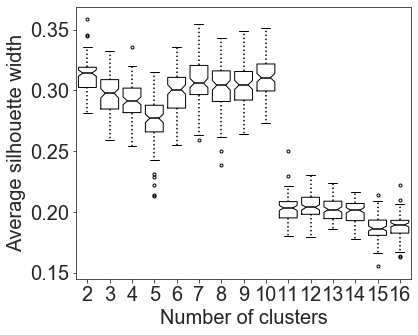

In [115]:
fig,ax = plot_avg_sil(sil_arr,
                 cs_range=[2,17],
                 save_path=None
                )

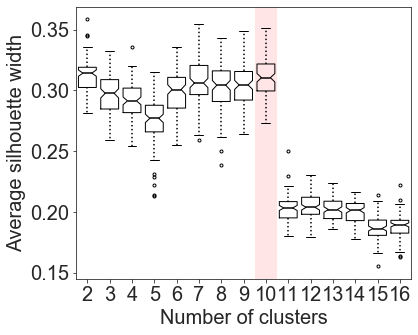

In [116]:
from matplotlib.path import Path
import matplotlib.patches as patches
def bg(x_start,y_end,x_end =9.5):
    verts = [
            (x_start, 0), 
            (x_start, y_end), 
            (x_end, y_end),
            (x_end, 0.),
            (x_start, 0.)   
        ]
    codes = [Path.MOVETO,Path.LINETO,Path.LINETO,Path.LINETO,Path.CLOSEPOLY]            
    path = Path(verts,codes) 
    early_patch = patches.PathPatch(path, facecolor='r', lw=0.1,alpha = 0.1)
    return early_patch
early_patch = bg(8.5,y_end =0.38)
ax.add_patch(early_patch)   
fig

## Fig1D: the compositional violin plot

In [48]:

import matplotlib.ticker as ticker 
from matplotlib.colors import to_hex

def setColorConf(colors,n_clusters):
    colors = list(plt.get_cmap(colors).colors)
    colors_list = [to_hex(color) for color in colors]
    colors_list = colors_list[:n_clusters]
class stackViolin():
    @staticmethod
    def setColorConf(self,colors,ngroups)->list:
        """
        return a list of colors.
        """ 
        if colors == "hcl":
            try:
                from colorspace import sequential_hcl
                color_repo = sequential_hcl(h=[15,375],l=65,c=70)
                colors_list =  color_repo.colors(ngroups + 1)
            except ImportError:
                print('hcl colorspace package has not being installed.')
                print('please try the following command:')
                print('pip install git+https://github.com/retostauffer/python-colorspace') 
        else:
            colors = list(plt.get_cmap(colors).colors)
            colors_list = [to_hex(color) for color in colors]
            colors_list = colors_list[:ngroups]

        return colors_list

    def __init__(self,
                featureDataFrame:pd.DataFrame,
                groupDataFrame:pd.DataFrame):
        """
        featureDataFrame:
            feature table with one feature-id(e.g. taxa1,taxa2) per columns and one row per sample-id.
        groupDataFrame:
            group information of sample-id, containing 2 columns: sample-id and its group info.
        """
        self.configure = {}
        ## TODO:check dataframe
        ## TODO:sort index of 2 df
        ## TODO:check if the index of 2 df consistence.
        if np.sum(featureDataFrame.index != groupDataFrame.index) !=0:
            raise IndexError("Unidentical index between featureDataFrame and groupDataFrame")
        

        self.violinDataFrame = self.createViolinDataFrame(featureDataFrame,groupDataFrame)
        

    def printConfig(self,kw):
        """
        maintain a plotting configure dict.
        """
        print(self.configure[kw])
        return self.configure[kw]

    def createViolinDataFrame(self,featureDataFrame,groupDataFrame):
        """
        each row a sample.
        new column names:sample-id/group/feature1/featur2/.../featuren

        """        
        violinDataFrame = featureDataFrame.join(groupDataFrame)
        self.configure['violinDataFrame'] = violinDataFrame
        return violinDataFrame

    def setAxesSize(self,fig,ith_axes,axes_unit_height):
        """
        ith_axes: the order of axes(denote by ith).
        """
        # first axes
        if ith_axes==0:
            size = [0,0,1,axes_unit_height]
            ax = fig.add_axes(size) # left start, bottom start ,right end ,top end
        else:
            #print(0,axes_unit_height*ith_axes,1,axes_unit_height)
            size = [0,np.round(axes_unit_height*ith_axes,2),1,axes_unit_height]
            ax = fig.add_axes(size)
        self.configure['axes_'+str(ith_axes)+'_size'] = size
        return ax

    def setTickConf(self,ax,ith_axes,ylabel):
        ax.tick_params(
            axis='y',
            left=False,
            right=True,
            labelright=True,
            labelleft=False,
            labelsize=13,
            length=1,
            pad=1,)

        ax.set_ylabel(
            ylabel,
            rotation=0,
            fontsize=13,
            labelpad=8,
            ha='right',
            va='center',)
        ax.set_ylim([-0.25,1.3])
        ax.set_xlabel('')
        
        if ith_axes > 0:
            ax.xaxis.set_major_locator(ticker.NullLocator())


    def setRotation(self,ax,xrotate):
        """
        xrotate:degree of xcord label rotation.
        """
        ## TODO:yrotate
        if isinstance(xrotate,int):
            for i in ax.xaxis.get_ticklabels():
                i.set_rotation(xrotate)
                i.set_fontsize(8)

    def plotViolin(self,
                    figsize=(10, 5),
                    order = None,
                    topfeature =15,
                    axes_unit_height=0.3,
                    orient="h",
                    color_palette="tab20",
                    xrotate = 0,
                    save_path="",
                    **kwargs):

        # get unique group from the last column(group info).
        group_name = self.violinDataFrame.columns[-1]
        groups = np.unique(self.violinDataFrame.iloc[:,-1].values)
        ngroups = len(groups)
        self.configure['groups'] = groups
        self.configure['n_groups'] = ngroups

        # get features from column names.
        features = self.violinDataFrame.columns[:-1]
        self.configure['features'] = features
        

        if not order:
            order = np.sort(groups)
        else:
            # check whether the set of provided order identical with groups.
            if set(order) != set(groups):
                raise ValueError("Unidentical values between provided order and groups.")
        
        fig = plt.figure(figsize=figsize)
        self.configure['figsize'] = figsize

        # if specified by user(passing a list).
        if isinstance(color_palette,list):
            colors_list = color_palette
            ## TODO:raise warning if len of list not consistent with ngroups.
        # if using matplotlib inner palette
        elif isinstance(color_palette,str):
            if color_palette:
                colors_list = self.setColorConf(self,colors=color_palette,ngroups = ngroups)
            else:
                colors_list = None
        self.configure['color_palette'] = colors_list

        # for loop adding stacked violin plot
        for i,feature in enumerate(features):
            ## TODO:orient
            ax = self.setAxesSize(fig,ith_axes=i,axes_unit_height=axes_unit_height)
            ax.grid(False)
            sns.violinplot(x=group_name, 
                        y=feature,
                        data=self.violinDataFrame, 
                        split=True, inner=None,
                        scale='width',
                        ax=ax,
                        palette=colors_list, 
                        order=order,
                        **kwargs)

            self.setTickConf(ax,ith_axes=i,ylabel = feature)
            
        
        if xrotate == 0:rotate=False
        else:rotate=True

        # if rotate x labels
        #if rotate:
        ax0 = fig.axes[0]
        self.setRotation(ax0,xrotate = xrotate) 
    
        sns.set_style('ticks')
        if save_path:
            plt.savefig(save_path,bbox_inches = 'tight',dpi=1000)
        return fig,ax

In [3]:
import os
os.chdir("E:/ncovKLZ/final_scripts_published")

0
0


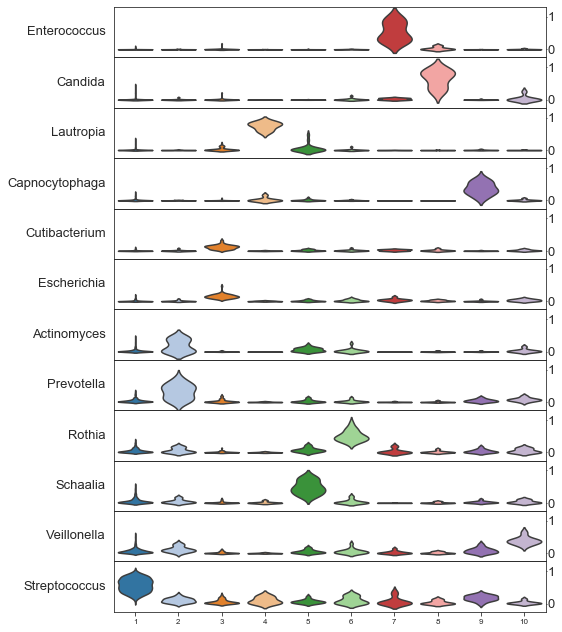

In [52]:
#### 只看每个群落大于5%的物种

df = pd.read_csv("fig1d/"+ 
                 'bind_genus_2_001_csfilter.csv',index_col = 0)  ## 和小于等于1
metadata = pd.read_csv('fig1d/'+
                       'bray_top_56_cord_hclust_complete_10.csv',index_col=0)
df = df.T
#df = df.iloc[:,:5]
df = df.sort_index()
sorted_feature = df.sum().sort_values(ascending=False).index  ##按物种丰度大小排序
sorted_f_list = list(sorted_feature)
df = df.loc[:,sorted_f_list]
metadata = metadata.sort_index()
print(np.sum(df.index != metadata.index))
new_df = df.join(metadata)
### 统计群落的平均值
mean_abd = new_df.groupby('cluster').mean()
bool_mean_abd = mean_abd >0.1
bool_mean_abd = bool_mean_abd.sum() !=0 ##在所有群落中都小于0.05的被过滤掉
bool_mean_abd_greater_5_percent = bool_mean_abd[bool_mean_abd]
df_filtered_with_5_percent = df.loc[:,bool_mean_abd_greater_5_percent.index]


metadata = metadata.sort_index()
print(np.sum(df.index != metadata.index))
sv = stackViolin(featureDataFrame=df_filtered_with_5_percent,groupDataFrame=metadata.cluster)
#print(sv.violinDataFrame)
fig,ax = sv.plotViolin(axes_unit_height=0.05,
                     figsize=(6,14 ),
                  save_path="fig1d/010_stackViolin_csfilter_axes01.pdf"
                  )
#plt.xlabel('Cluster')

## Supplemantary-Fig 1J: permutational analysis

In [117]:
from copy import deepcopy
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import random

def get_obs_pos(df,target_cs):
    cs_vec = df.values.flatten()
    # get the pos of non-target-cs
    #sampling_vec = [True if (i !=target_cs and i !=-1 ) else False for i in cs_vec]
    
    # 获取所有非-1的位置
    sampling_vec = [True if i !=-1  else False for i in cs_vec]
    return [i for i,j in enumerate(sampling_vec) if j]

def span_list(trans_meta):
    # get the max
    len_ = 0
    for i in trans_meta:
        len_i = len(i)
        if len_i >len_:
            len_ = len_i
    print("max length",len_)
    df = pd.DataFrame(trans_meta)
    return df.fillna(-1)

def get_new_df(trans_df,fill=0):
    return (trans_df != -1 ).replace({True:fill,False:-1})

def sampling(trans_df,sampling_pos):
    pos = random.sample(sampling_pos,1)[0] 
    if pos < trans_df.shape[1]:
        pert_subj = 0
        pert_day = pos
    else:
        pert_day = int(pos % trans_df.shape[1])
        pert_subj = int((pos - pert_day) / trans_df.shape[1])
        
    return pert_subj,pert_day

def isnan(obj):
    if isinstance(obj,str):
        return False
    if isinstance(obj,float):
        if math.isnan(obj):
            return True
        else:
            return False
        
def listRemoveNAN(arr_):
    """
    Remove NaN in the list.
    list_:list-like object.
    """
    for idx,list_ in enumerate(arr_):
        list_new = []
        for i,val in enumerate(list(list_)):
            # float/nan
            if isinstance(val,float): 
                if math.isnan(val):
                    continue
                else:
                    list_new.append(val)
            # int,str,etc.
            else:
                list_new.append(val)
        arr_[idx] = list_new
    return arr_

def stat_gt2(df,target_cs,num):
    i = 0
    for subj in df.index:
        cur_row = df.loc[subj,:] 
        tmp = len([i for i in cur_row  if i ==target_cs])
        if tmp >=num:
            i+=1
    return i

def permutate(trans_meta,target_cs,permut_round=2000,stat_num=2,verb=True):
    res = []
    nsubj = len(trans_meta)
    trans_df = span_list(trans_meta)
    before_num = stat_gt2(trans_df,target_cs,num = stat_num)
    print("observed target cs >=2 num:",before_num)

    
    
    for iter_ in range(permut_round): 

        # 1.get the sampling pos (not -1)    
        sampling_pos = get_obs_pos(trans_df,target_cs)  
        
        # 2.get a new copy df
        trans_df_copy = get_new_df(trans_df)
        
        # 3.get the number of target cs
        cs_num = (trans_df ==target_cs).sum().sum()
        
        # 4.the sampling process
        for iter2_ in range(cs_num):
            #print(sampling_pos)
            new_subj,new_day = sampling(trans_df,sampling_pos)
            trans_df_copy.loc[new_subj,new_day] = target_cs
            
            # remove the sampled pos from sampling pos
            num = new_subj * trans_df.shape[1] + new_day
            sampling_pos.remove(num)
        
        if verb:
            print("round",str(iter_)," done")

        ret = stat_gt2(trans_df_copy,target_cs,stat_num)
        res.append(ret)

    return before_num,res,trans_df_copy 




In [118]:
import pandas as pd
trans_meta = pd.read_excel("permutation test/trans_meta_wpl.xlsx",index_col=0)
trans_meta = trans_meta.loc[:,['d1','d5','d10','d14','d21']]


## remove subject with only 1 sample
multi_sams_subj = []
for i in trans_meta.index:
    cur_subj_trans = trans_meta.loc[i,:]
    num = sum(cur_subj_trans.notna())
    if num>1:
        multi_sams_subj.append(i)
trans_meta = trans_meta.loc[multi_sams_subj,:]
trans_meta = listRemoveNAN(list(trans_meta.values))


In [119]:

## permutation
before_num,res,df =permutate(trans_meta,target_cs =3,permut_round=2000)

pd.DataFrame(res).to_csv("E:/ncovKLZ/review2nd/CS3_Permutation_res.csv")     

max length 5
observed target cs >=2 num: 7
round 0  done
round 1  done
round 2  done
round 3  done
round 4  done
round 5  done
round 6  done
round 7  done
round 8  done
round 9  done
round 10  done
round 11  done
round 12  done
round 13  done
round 14  done
round 15  done
round 16  done
round 17  done
round 18  done
round 19  done
round 20  done
round 21  done
round 22  done
round 23  done
round 24  done
round 25  done
round 26  done
round 27  done
round 28  done
round 29  done
round 30  done
round 31  done
round 32  done
round 33  done
round 34  done
round 35  done
round 36  done
round 37  done
round 38  done
round 39  done
round 40  done
round 41  done
round 42  done
round 43  done
round 44  done
round 45  done
round 46  done
round 47  done
round 48  done
round 49  done
round 50  done
round 51  done
round 52  done
round 53  done
round 54  done
round 55  done
round 56  done
round 57  done
round 58  done
round 59  done
round 60  done
round 61  done
round 62  done
round 63  done
round 6

round 518  done
round 519  done
round 520  done
round 521  done
round 522  done
round 523  done
round 524  done
round 525  done
round 526  done
round 527  done
round 528  done
round 529  done
round 530  done
round 531  done
round 532  done
round 533  done
round 534  done
round 535  done
round 536  done
round 537  done
round 538  done
round 539  done
round 540  done
round 541  done
round 542  done
round 543  done
round 544  done
round 545  done
round 546  done
round 547  done
round 548  done
round 549  done
round 550  done
round 551  done
round 552  done
round 553  done
round 554  done
round 555  done
round 556  done
round 557  done
round 558  done
round 559  done
round 560  done
round 561  done
round 562  done
round 563  done
round 564  done
round 565  done
round 566  done
round 567  done
round 568  done
round 569  done
round 570  done
round 571  done
round 572  done
round 573  done
round 574  done
round 575  done
round 576  done
round 577  done
round 578  done
round 579  done
round 58

round 1032  done
round 1033  done
round 1034  done
round 1035  done
round 1036  done
round 1037  done
round 1038  done
round 1039  done
round 1040  done
round 1041  done
round 1042  done
round 1043  done
round 1044  done
round 1045  done
round 1046  done
round 1047  done
round 1048  done
round 1049  done
round 1050  done
round 1051  done
round 1052  done
round 1053  done
round 1054  done
round 1055  done
round 1056  done
round 1057  done
round 1058  done
round 1059  done
round 1060  done
round 1061  done
round 1062  done
round 1063  done
round 1064  done
round 1065  done
round 1066  done
round 1067  done
round 1068  done
round 1069  done
round 1070  done
round 1071  done
round 1072  done
round 1073  done
round 1074  done
round 1075  done
round 1076  done
round 1077  done
round 1078  done
round 1079  done
round 1080  done
round 1081  done
round 1082  done
round 1083  done
round 1084  done
round 1085  done
round 1086  done
round 1087  done
round 1088  done
round 1089  done
round 1090  do

round 1514  done
round 1515  done
round 1516  done
round 1517  done
round 1518  done
round 1519  done
round 1520  done
round 1521  done
round 1522  done
round 1523  done
round 1524  done
round 1525  done
round 1526  done
round 1527  done
round 1528  done
round 1529  done
round 1530  done
round 1531  done
round 1532  done
round 1533  done
round 1534  done
round 1535  done
round 1536  done
round 1537  done
round 1538  done
round 1539  done
round 1540  done
round 1541  done
round 1542  done
round 1543  done
round 1544  done
round 1545  done
round 1546  done
round 1547  done
round 1548  done
round 1549  done
round 1550  done
round 1551  done
round 1552  done
round 1553  done
round 1554  done
round 1555  done
round 1556  done
round 1557  done
round 1558  done
round 1559  done
round 1560  done
round 1561  done
round 1562  done
round 1563  done
round 1564  done
round 1565  done
round 1566  done
round 1567  done
round 1568  done
round 1569  done
round 1570  done
round 1571  done
round 1572  do

In [122]:
## pvalue
res.sort()
print(sum(np.array(res) >7)/len(res))

0.037


([<matplotlib.axis.XTick at 0x1bd19d797f0>,
 <a list of 12 Text xticklabel objects>)

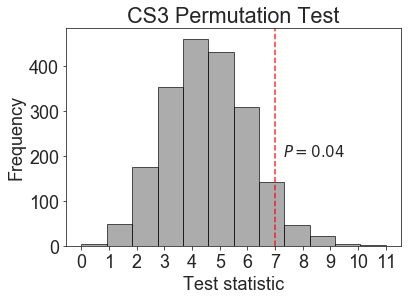

In [123]:
res = pd.DataFrame(res)
## vis
plt.rc('font', size=18)
plt.rc('font', family='Arial')
fig = plt.figure(figsize=(6,4))
#fig.set_facecolor('white')
ax = fig.subplots()
ax.hist(res.values,bins=12,
        #color='#F8766D',
        color='grey',alpha=0.65,
        edgecolor='black')
ax.set_xlabel("Test statistic")
ax.set_ylabel("Frequency")
ax.set_title("CS3 Permutation Test")
ax.axvline(7, ls='--', color='r',alpha=0.8)
ax.text(7.3,200,r"$P=0.04$",fontsize=15)
plt.xticks(np.arange(min(res.values), max(res.values)+1, 1))

# Dynamic analysis

In [134]:
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm
import matplotlib as mpl
import math
def get_colormaping(death_rate_df):

    color_map = defaultdict(dict)
    name_map = {
        'T1':'layer1',
        'T2':'layer2',
    }
    norm = plt.Normalize(0,1)
    for day in ['T1','T2']:
        for i in death_rate_df.index:
            rate = death_rate_df.loc[i,day]
            if math.isnan(rate):
                continue
            else:
                arr = plt.cm.Oranges(norm([rate]))
                c_hex = mpl.colors.to_hex(arr[0])
                color_map[name_map[day]][i] = c_hex
    return color_map

def get_death_rate(meta):
    rate_df = pd.DataFrame()
    tmp = meta.groupby(['Time_new','top56_cs_1','Death']).count()
    tmp = tmp.reset_index()
    for i in set(tmp.Time_new):
        print('===== Time:',i,' ======')
        tot_death = 0
        tot_ndeath = 0
        
        cur_tmp = tmp.loc[tmp.Time_new == i,:]
        
        d_tmp = cur_tmp[cur_tmp.Death ==1]
        nd_tmp = cur_tmp[cur_tmp.Death ==0]
        for cs in [1,2,3,4,5,6,7,8,9,10,11]:
            #print('>>>cs:',cs)
            try:
                death = d_tmp[d_tmp.loc[:,'top56_cs_1']==cs].Sample_ID2.values[0]
            except:
                death = 0
            try:
                ndeath = nd_tmp[nd_tmp.loc[:,'top56_cs_1'] ==cs ].Sample_ID2.values[0]
            except:
                ndeath = 0
            
            try:
                
                rate_df.loc[cs,i] = death/(ndeath +death)
                
                #print('death num:',death)
                #print('ndeath num:',ndeath)
                #print('rate:', death/(ndeath +death))
                
                tot_death +=death
                tot_ndeath += ndeath
            except:
                if death ==0:
                    rate_df.loc[cs,i] = 0
                if ndeath ==0:
                    rate_df.loc[cs,i] = 1
                #print('death num:',death)
                #print('ndeath num:',ndeath)
                #print('rate')
        #print("total death at",i,':',tot_death)
        #print("total ndeath at",i,':',tot_ndeath)
            #rate = rate.fillna(0)
        #for i in rate.index:
        #    rate_df.loc[i,day] = rate.loc[i,'Individual_ID']  
    return tmp,rate_df

## Fig5B: sankey diagram

we developed pySankey2 for showing static Sankey diagrams based on matplotlib. See details in : https://github.com/SZJShuffle/pySankey2

In [135]:
import pandas as pd
metadata = pd.read_excel('E:/ncovKLZ/final_scripts_published/fig5b/meta_20210106.xlsx',index_col=0)

metadata =metadata[metadata.reads_gthan3000 =='yes']
metadata =metadata[metadata.Sample_ID2 !='health']
metadata =metadata[metadata.Sample_ID2 !='NC']


ret_df,death_rate= get_death_rate(metadata)
death_rate.index =death_rate.index.astype(str)
tmp = metadata[metadata.Time_new !='other']

===== Time: other  ======
===== Time: T2  ======
===== Time: T1  ======


In [136]:
death_rate

,other,T2,T1
1,0.069307,0.044248,0.132530
2,0.111111,1.000000,0.222222
3,0.300000,0.153846,0.500000
4,0.000000,0.500000,0.500000
5,0.000000,0.200000,0.000000
6,0.500000,0.428571,0.250000
7,0.400000,0.666667,0.500000
8,0.500000,1.000000,1.000000
9,1.000000,0.250000,1.000000
10,0.250000,1.000000,0.500000


### deceased

In [ ]:
death_sankey_df = pd.DataFrame()
for i in tmp.index:
    if tmp.loc[i,'Death']  ==1:
        subj = tmp.loc[i,'Individual_ID2']
        time = tmp.loc[i,'Time_new']
        cs = tmp.loc[i,'top56_cs_1']
        death_sankey_df.loc[subj,time] = cs
death_df = death_sankey_df.dropna(axis=0,how='any')

In [130]:
cmap = get_colormaping(death_rate)

In [131]:
## to str
for i in death_df.index:
    for j in ['T1','T2']:
        if death_df.loc[i,j] !='others':
            death_df.loc[i,j] =  str(int(death_df.loc[i,j]))

C:\Users\lxm\Anaconda3\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [132]:

del cmap['layer1']['5']
del cmap['layer1']['6']
del cmap['layer1']['8']
del cmap['layer1']['9']


del cmap['layer2']['2']
del cmap['layer2']['9']


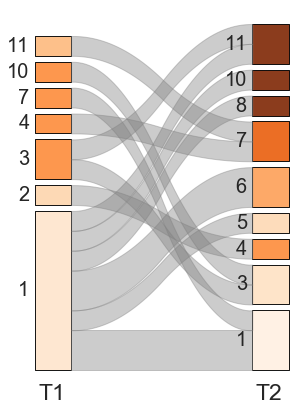

In [137]:

from collections import defaultdict
from collections import OrderedDict

from matplotlib import pyplot as plt 
import matplotlib.ticker as ticker
import matplotlib.cm as cm
#import matplotlib
import matplotlib as mpl
from pysankey2 import Sankey

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42


death_df.columns = ['layer1','layer2']
dlayer_labs = OrderedDict({'layer1':['1', '2', '3', '4', '7', '10', '11'],
             'layer2':['1', '3', '4', '5', '6', '7', '8', '10', '11']})

colors=cmap
norm = plt.Normalize(0,1)

sk = Sankey(death_df,
            colorDict=colors,
            colorMode="layer",
            layerLabels=dlayer_labs,
           )
fig,ax = sk.plot(figSize=(5,7),box_kws={'edgecolor':'black'}, 
                 fontSize=20)

days=['T1','T2']
i=0
for layer in sk.layerPos.keys():
    pos = sk.layerPos[layer]['layerStart']
    ax.text(pos+0.19,-1.5,days[i],fontsize=23)
    i+=1


fig.savefig("E:/ncovKLZ/final_scripts_published/fig5b/death_T1T2_sankey.pdf",bbox_inches='tight', dpi=800)

### recovered

In [138]:
ndeath_sankey_df = pd.DataFrame()
for i in tmp.index:
    if tmp.loc[i,'Death']  ==0:
        subj = tmp.loc[i,'Individual_ID2']
        time = tmp.loc[i,'Time_new']
        cs = tmp.loc[i,'top56_cs_1']
        ndeath_sankey_df.loc[subj,time] = cs
ndeath_df = ndeath_sankey_df.dropna(axis=0,how='any')

In [139]:
## to str
for i in ndeath_df.index:
    for j in ['T1','T2']:
        if ndeath_df.loc[i,j] !='others':
            ndeath_df.loc[i,j] =  str(int(ndeath_df.loc[i,j]))

C:\Users\lxm\Anaconda3\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [140]:
cmap = get_colormaping(death_rate)

In [141]:
del cmap['layer1']['8']
del cmap['layer1']['9']

del cmap['layer2']['2']
del cmap['layer2']['8']
del cmap['layer2']['10']
del cmap['layer2']['11']

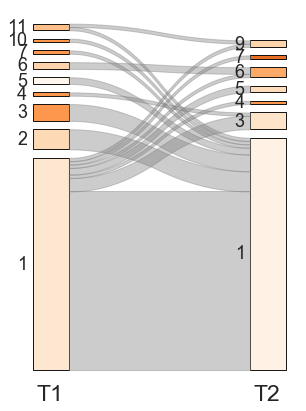

In [143]:
ndeath_df.columns = ['layer1','layer2']
dlayer_labs = OrderedDict({'layer1':['1', '2', '3', '4', '5', '6', '7', '10', '11'],
             'layer2':['1', '3', '4', '5', '6', '7', '9']})

colors=cmap
norm = plt.Normalize(0,1)

sk = Sankey(ndeath_df,
            colorDict=colors,
            colorMode="layer",
            layerLabels=dlayer_labs,
           )
fig,ax = sk.plot(figSize=(5,7),box_kws={'edgecolor':'black'}, 
                  boxInterv=0.03,
                 fontSize=18)

days=['T1','T2']
i=0
for layer in sk.layerPos.keys():
    pos = sk.layerPos[layer]['layerStart']
    ax.text(pos+0.19,-9,days[i],fontsize=23)
    i+=1

fig.savefig("E:/ncovKLZ/final_scripts_published/fig5b/ndeath_T1T2_sankey.pdf",bbox_inches='tight', dpi=800)

## Fig5D: markov chain

done


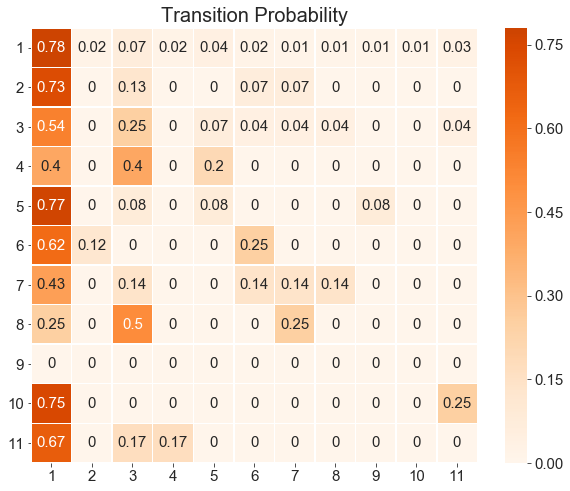

In [146]:
import numpy as np
import seaborn as sns
import os
import pandas as pd
from matplotlib import pyplot as plt
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = '15'
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

files={'ts_trans_matrix_wpl.csv':''}
for file in files.keys():

    trans = pd.read_csv("E:/ncovKLZ/final_scripts_published/fig5d/" + file,index_col =0)
    trans = np.round(trans,2)
    fig = plt.figure(figsize=(10,8))
    ax = fig.subplots()
    ax= sns.heatmap(trans,
                cmap='Oranges',
                ax= ax,
                center=0.5,linewidths=.5,annot=True)
    plt.title('Transition Probability',size=20)
    plt.yticks(rotation=0) 

    plt.savefig("fig5d/" + files[file] + ".pdf",dpi=800,bbox_inches="tight")
    #plt.close()
print("done")